#  Reference: Transfer Learning and Convolutional Neural Networks (CNN) 

https://medium.com/mlearning-ai/transfer-learning-and-convolutional-neural-networks-cnn-e68db4c48cca

# Package Installations

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import splitfolders
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50  import preprocess_input

# Unzip image files and move to right folders


In [4]:
! unzip '/content/drive/MyDrive/omdena_liverpool_all/C-NMC_Leukemia/training_data/new_all_hem_crop'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: new_hem_crop/aug__278_6058.bmp  
  inflating: new_hem_crop/aug__2780_9567.bmp  
  inflating: new_hem_crop/aug__2781_8552.bmp  
  inflating: new_hem_crop/aug__2782_4329.bmp  
  inflating: new_hem_crop/aug__2783_8894.bmp  
  inflating: new_hem_crop/aug__2784_9120.bmp  
  inflating: new_hem_crop/aug__2784_9703.bmp  
  inflating: new_hem_crop/aug__2785_476.bmp  
  inflating: new_hem_crop/aug__2786_5975.bmp  
  inflating: new_hem_crop/aug__2787_1010.bmp  
  inflating: new_hem_crop/aug__2788_1541.bmp  
  inflating: new_hem_crop/aug__2789_7227.bmp  
  inflating: new_hem_crop/aug__279_2826.bmp  
  inflating: new_hem_crop/aug__2790_1239.bmp  
  inflating: new_hem_crop/aug__2791_5896.bmp  
  inflating: new_hem_crop/aug__2792_8352.bmp  
  inflating: new_hem_crop/aug__2793_5034.bmp  
  inflating: new_hem_crop/aug__2794_7822.bmp  
  inflating: new_hem_crop/aug__2794_9885.bmp  
  inflating: new_hem_crop/aug__2795_5970.bmp  
  in

In [5]:
!mkdir data


In [6]:
!mkdir data/class_data

In [7]:
!mv new_hem_crop  ./data/class_data/hem

In [8]:
!mv new_all_crop ./data/class_data/all

In [9]:
!mkdir ./data/set_data

# Split Data into Train/Val/Test Folders

In [10]:
splitfolders.ratio(
    "./data/class_data/", 
    output="./data/set_data/", 
    seed=21, 
    ratio=(0.8, 0.1, 0.1), 
    group_prefix=None
)

Copying files: 14562 files [00:02, 5670.92 files/s]


# Create Train, Val and Test sets

In [11]:
batch_size = 32
img_height = 150
img_width = 150
data_dir_train ="./data/set_data/train"
data_dir_val = "./data/set_data/val"
data_dir_test = "./data/set_data/test"

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
    seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11649 files belonging to 2 classes.


In [13]:
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
    seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1456 files belonging to 2 classes.


In [14]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1457 files belonging to 2 classes.


# Plot samples

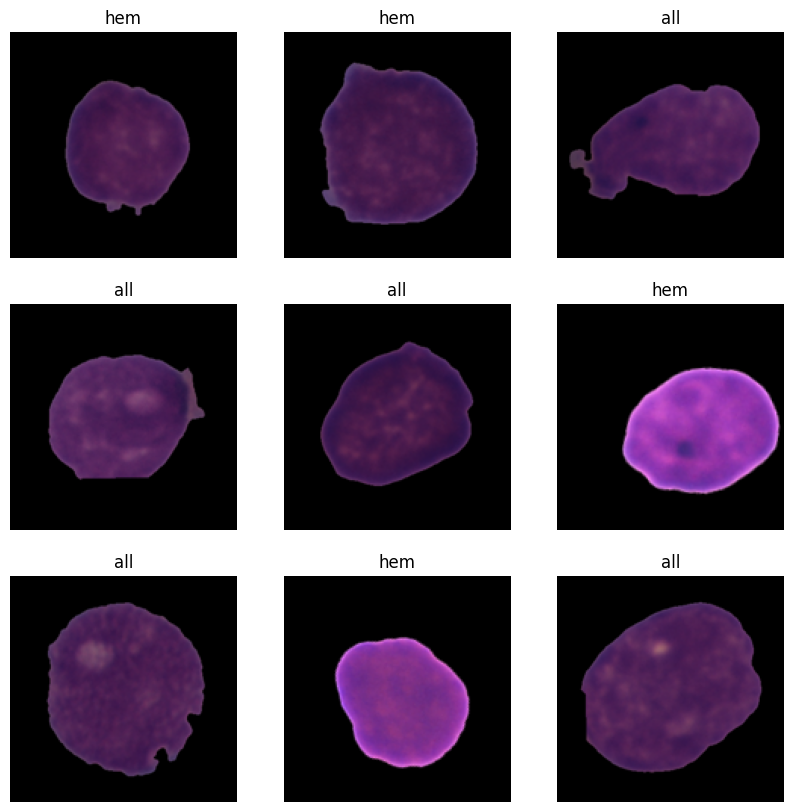

In [15]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Initialize and Train Model

In [16]:
pre_trained_model = ResNet50(input_shape=(img_height,img_width,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

94765736/94765736 [==============================] - 5s 0us/step


In [17]:
tf.random.set_seed(21)

model = tf.keras.models.Sequential([
    pre_trained_model,
    GlobalAveragePooling2D(),    
    Dense(512,activation="swish"),
    Dropout(0.7),
    Dense(256,activation="swish"),
    Dropout(0.5),
    Dense(128,activation="swish"),
    Dropout(0.3), 
    Dense(32,activation="tanh"),
    Dropout(0.2), 
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [18]:
%%time

history = model.fit(
    train_dataset,
    steps_per_epoch=200,
    epochs=2,
    validation_data=valid_dataset,  
)

Epoch 1/2
200/200 [==============================] - 20s 26ms/step - loss: 0.4599 - accuracy: 0.7905 - val_loss: 0.3390 - val_accuracy: 0.8613
Epoch 2/2
165/200 [=======================>......] - ETA: 0s - loss: 0.3561 - accuracy: 0.8565

200/200 [==============================] - 4s 20ms/step - loss: 0.3561 - accuracy: 0.8565 - val_loss: 0.3445 - val_accuracy: 0.8661
CPU times: user 21.2 s, sys: 3.12 s, total: 24.3 s
Wall time: 24.4 s


# Evaluate Feature Extraction + Classification on Test Set

In [19]:
test_labels=[]
for images, labels in test_dataset.unbatch():
    test_labels.append(labels) # or labels.numpy().argmax() for int labels
test_labels = np.array(test_labels)

In [20]:
class_names = test_dataset.class_names
predictions = model.predict_generator(test_dataset)
predictions = predictions.reshape(1,-1)[0]>0.5

print(classification_report(test_labels, predictions, target_names = class_names))

              precision    recall  f1-score   support

         all       0.50      0.59      0.54       728
         hem       0.49      0.40      0.44       729

    accuracy                           0.50      1457
   macro avg       0.50      0.50      0.49      1457
weighted avg       0.50      0.50      0.49      1457



# Preparing X and y matrix/vectors for ML classification algorithms

In [21]:
X_train_feat = pre_trained_model.predict_generator(train_dataset)
X_val_feat = pre_trained_model.predict_generator(valid_dataset)
X_test_feat = pre_trained_model.predict_generator(test_dataset)

In [22]:
X_train = X_train_feat.reshape(X_train_feat.shape[0], -1)
X_val = X_val_feat.reshape(X_val_feat.shape[0], -1)
X_test = X_test_feat.reshape(X_test_feat.shape[0], -1)


In [23]:
((X_train.shape), (X_val.shape), (X_test.shape))

((11649, 51200), (1456, 51200), (1457, 51200))

In [24]:
y_train =[]
for images, labels in train_dataset.unbatch():
    y_train.append(labels) 
y_train = np.array(y_train)


y_val =[]
for images, labels in valid_dataset.unbatch():
    y_val.append(labels) 
y_val = np.array(y_val)


y_test =[]
for images, labels in test_dataset.unbatch():
    y_test.append(labels) 
y_test = np.array(y_test)

In [25]:
((y_train.shape), (y_val.shape), (y_test.shape))

((11649,), (1456,), (1457,))

# Feature Scaling

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.fit_transform(X_val)
X_test_s = scaler.fit_transform(X_test)

# Classification - Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm= confusion_matrix(y_test,y_pred)

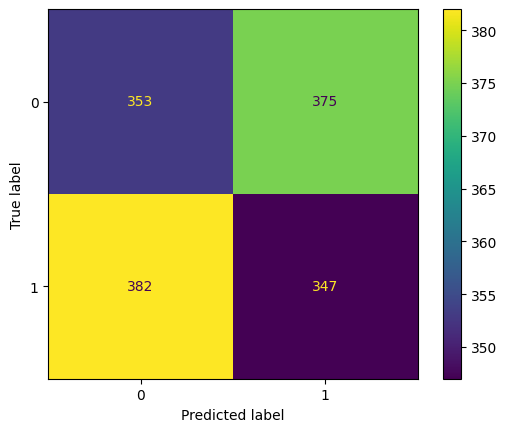

In [29]:
import seaborn as sns
%matplotlib inline  
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [30]:
print(classification_report(y_train, clf.predict(X_train_s)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5817
           1       0.99      1.00      0.99      5832

    accuracy                           0.99     11649
   macro avg       0.99      0.99      0.99     11649
weighted avg       0.99      0.99      0.99     11649



In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       728
           1       0.48      0.48      0.48       729

    accuracy                           0.48      1457
   macro avg       0.48      0.48      0.48      1457
weighted avg       0.48      0.48      0.48      1457



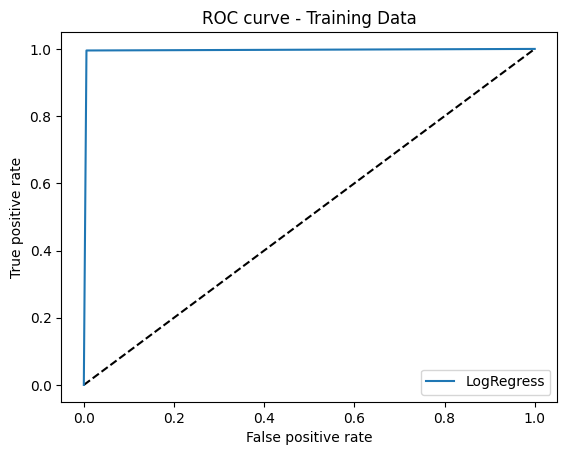

In [32]:
from sklearn.metrics import roc_curve, auc
fpr_rf, tpr_rf, _ = roc_curve(y_train, clf.predict(X_train_s))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LogRegress')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Training Data')
plt.legend(loc='best')
plt.show()

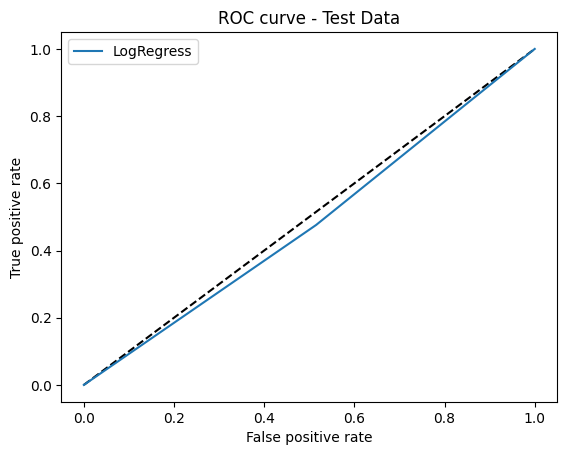

In [33]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, clf.predict(X_test_s))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='LogRegress')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data')
plt.legend(loc='best')
plt.show()

# Classification with Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [100]:
RF_model.fit(X_train_s, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

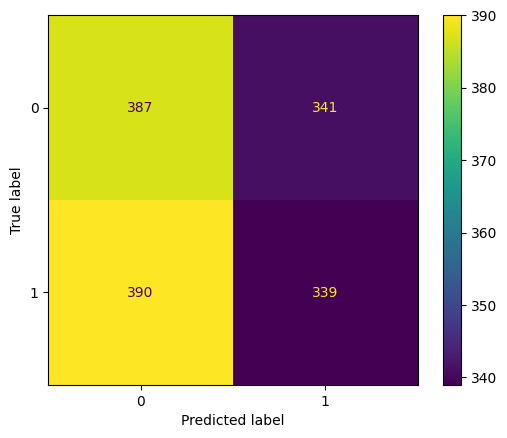

In [101]:
y_pred = RF_model.predict(X_test_s)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [102]:
print(classification_report(y_train, RF_model.predict(X_train_s), target_names = ['all','hem']))

              precision    recall  f1-score   support

         all       1.00      1.00      1.00      5817
         hem       1.00      1.00      1.00      5832

    accuracy                           1.00     11649
   macro avg       1.00      1.00      1.00     11649
weighted avg       1.00      1.00      1.00     11649



In [103]:
print(classification_report(y_test, y_pred, target_names = ['all','hem']))

              precision    recall  f1-score   support

         all       0.50      0.53      0.51       728
         hem       0.50      0.47      0.48       729

    accuracy                           0.50      1457
   macro avg       0.50      0.50      0.50      1457
weighted avg       0.50      0.50      0.50      1457



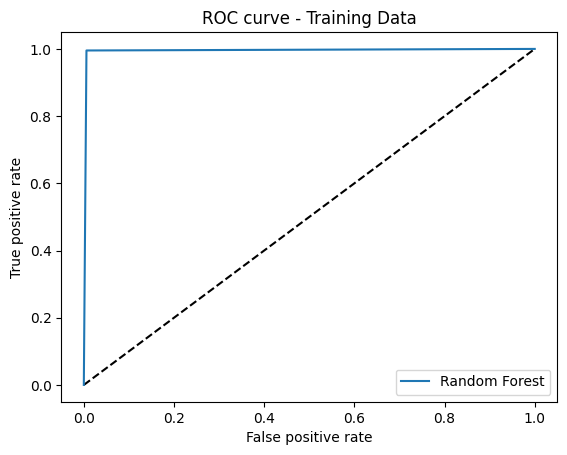

In [39]:
fpr_rf, tpr_rf, _ = roc_curve(y_train, clf.predict(X_train_s))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Training Data')
plt.legend(loc='best')
plt.show()

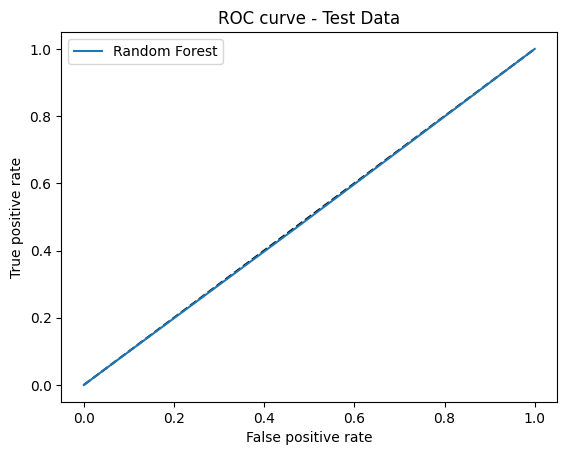

In [40]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, RF_model.predict(X_test_s))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data')
plt.legend(loc='best')
plt.show()

# Feature Importance Selection by Random Forest

In [41]:
import time

start_time = time.time()
importances = RF_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.061 seconds


In [42]:
import pandas as pd
forest_importances = pd.Series(importances)



In [43]:
# select features with cumulative sum of importance up to 80% in ascending order
selected_features = forest_importances[forest_importances.sort_values(ascending=False).cumsum()<0.8].copy()

In [44]:
selected_features.index

Int64Index([    8,    17,    22,    24,    33,    52,    55,    87,    89,
              101,
            ...
            51166, 51170, 51171, 51176, 51178, 51184, 51185, 51187, 51192,
            51196],
           dtype='int64', length=11769)

In [45]:
X_train.shape

(11649, 51200)

In [46]:
X_train_select = X_train[:,selected_features.index]
X_train_s_select = X_train_s[:,selected_features.index]
X_val_select = X_val[:,selected_features.index]
X_val_s_select = X_val_s[:,selected_features.index]
X_test_select = X_test[:,selected_features.index]
X_test_s_select = X_test_s[:,selected_features.index]

In [47]:
(X_train_select.shape,X_val_select.shape,X_test_select.shape)

((11649, 11769), (1456, 11769), (1457, 11769))

# Random Forest Classification with Feature Importance Selection

In [48]:
RF_model.fit(X_train_s_select, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

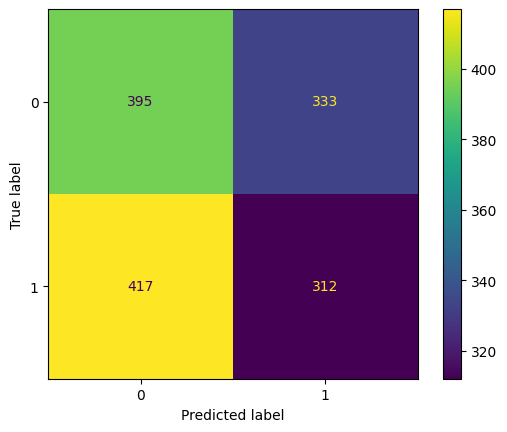

In [49]:
y_pred = RF_model.predict(X_test_s_select)
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [50]:
print(classification_report(y_train, RF_model.predict(X_train_s_select)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5817
           1       1.00      1.00      1.00      5832

    accuracy                           1.00     11649
   macro avg       1.00      1.00      1.00     11649
weighted avg       1.00      1.00      1.00     11649



In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.54      0.51       728
           1       0.48      0.43      0.45       729

    accuracy                           0.49      1457
   macro avg       0.49      0.49      0.48      1457
weighted avg       0.49      0.49      0.48      1457



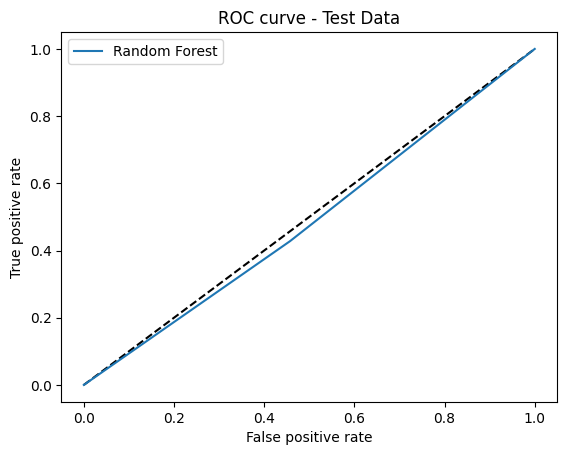

In [52]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, RF_model.predict(X_test_s_select))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test Data')
plt.legend(loc='best')
plt.show()

# Classification - Neural Networks

In [54]:
X_train_select.shape[1]

11769

In [80]:
tf.random.set_seed(21)

modelNN = tf.keras.models.Sequential([
    Dense(X_train_select.shape[1],activation="relu", input_shape = [X_train_select.shape[1]]),
    Dense(1024,activation="relu"),
    #Dropout(0.9),
    Dense(512,activation="relu"),
    #Dropout(0.7),
    Dense(256,activation="relu"),
    Dropout(0.5),
    Dense(128,activation="relu"),
    Dropout(0.3), 
    Dense(64,activation="relu"),
    Dropout(0.2), 
    Dense(32,activation="relu"),
    Dropout(0.1), 
    Dense(1, activation='sigmoid')
])

modelNN.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [81]:
%%time
#early_stopping = tf.keras.callbacks.EarlyStopping(
#    patience=10,
#    min_delta=0.001,
#    restore_best_weights=True,
#)

history = modelNN.fit(
    X_train_s_select, y_train,
    validation_data=(X_val_s_select, y_val),
    batch_size=32,
    epochs=100,
    #callbacks=[early_stopping],
    verbose=True, 
)

Epoch 1/100
365/365 [==============================] - 5s 8ms/step - loss: 0.7582 - accuracy: 0.5030 - val_loss: 0.7008 - val_accuracy: 0.5007
Epoch 2/100
365/365 [==============================] - 3s 8ms/step - loss: 0.7233 - accuracy: 0.5015 - val_loss: 0.6939 - val_accuracy: 0.5103
Epoch 3/100
365/365 [==============================] - 3s 8ms/step - loss: 0.7067 - accuracy: 0.5062 - val_loss: 0.6952 - val_accuracy: 0.5048
Epoch 4/100
365/365 [==============================] - 3s 8ms/step - loss: 0.7058 - accuracy: 0.5067 - val_loss: 0.6944 - val_accuracy: 0.5103
Epoch 5/100
365/365 [==============================] - 3s 8ms/step - loss: 0.7031 - accuracy: 0.5041 - val_loss: 0.6951 - val_accuracy: 0.4657
Epoch 6/100
365/365 [==============================] - 3s 8ms/step - loss: 0.7016 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5172
Epoch 7/100
365/365 [==============================] - 3s 8ms/step - loss: 0.6984 - accuracy: 0.5073 - val_loss: 0.6940 - val_accuracy: 0.4863

In [82]:
# evaluate model
lss, acc = modelNN.evaluate(X_test_s_select, y_test)
print("Model loss: ", lss)
print("Model accuracy: ", (acc * 100.0))

46/46 [==============================] - 0s 3ms/step - loss: 5.3452 - accuracy: 0.5182
Model loss:  5.345164775848389
Model accuracy:  51.81880593299866


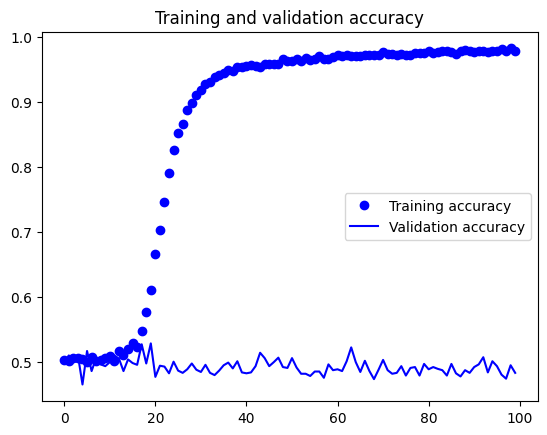

Model accuracy:  51.81880593299866


In [83]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("Model accuracy: ", (acc * 100.0))

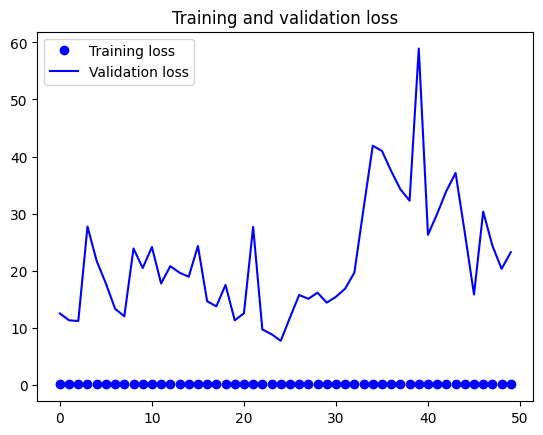

In [79]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [86]:
y_pred = modelNN.predict(X_test_s_select)
y_pred = np.argmax(np.round(y_pred),axis=1)

46/46 [==============================] - 0s 2ms/step


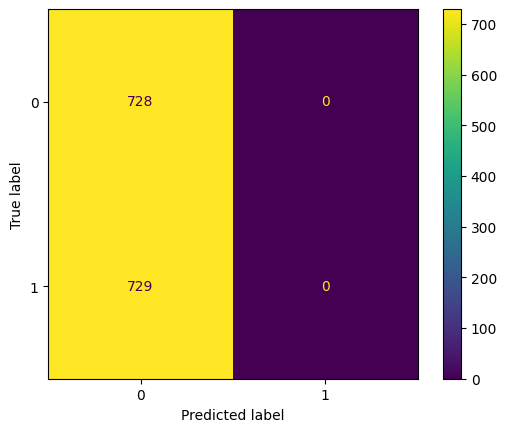

In [97]:
cm= confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [90]:
print(classification_report(y_test, y_pred, target_names = ['all','hem']))

              precision    recall  f1-score   support

         all       0.50      1.00      0.67       728
         hem       0.00      0.00      0.00       729

    accuracy                           0.50      1457
   macro avg       0.25      0.50      0.33      1457
weighted avg       0.25      0.50      0.33      1457

